1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?	
- KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?	
- U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?	 
- U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

## Step 1. KITTI 데이터셋 수집과 구축

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

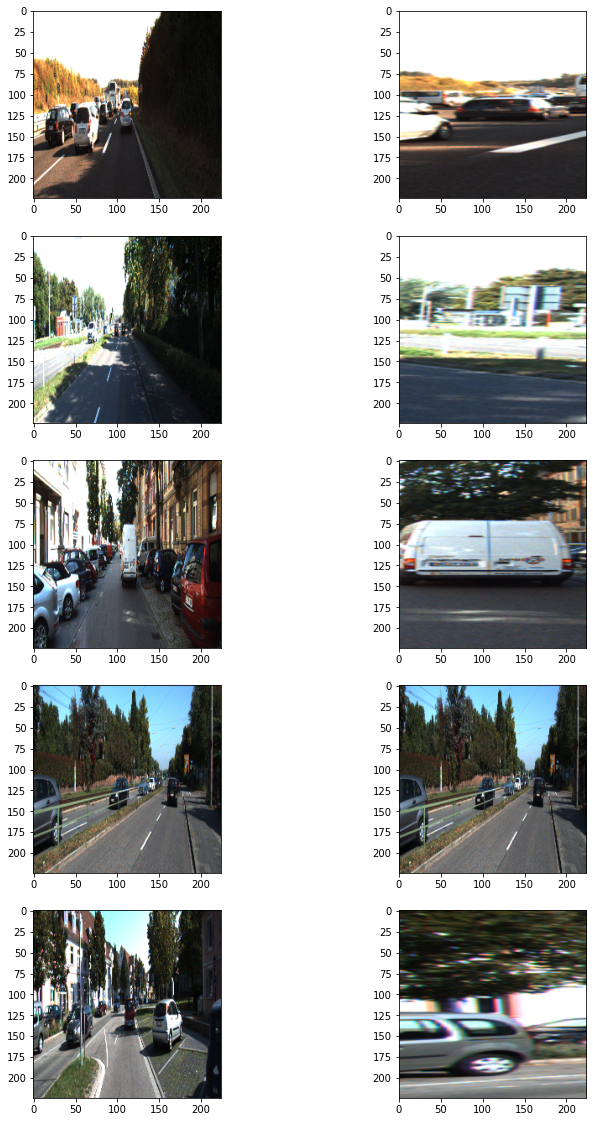

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
import os
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt

def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(  # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(  # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    else:  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
        return Compose([
            Resize(
                width=224,
                height=224
            )
        ])

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image": image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [22]:
import os
import numpy as np
import math
from glob import glob
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [4]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Convolutional block
def conv_block_plus(input_tensor, num_filters, dropout_rate=0.0):
    x = layers.Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = layers.Activation("relu")(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = layers.Activation("relu")(x)
    return x

# Encoder block
def encoder_block_plus(input_tensor, num_filters):
    x = conv_block_plus(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

# Decoder block using Transpose2D
def decoder_block_plus(input_tensor, concat_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=-1)
    x = conv_block_plus(x, num_filters)
    return x

# Build U-Net++ model
def build_unetplusplus(input_shape=(224, 224, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x1, p1 = encoder_block_plus(inputs, 64)
    x2, p2 = encoder_block_plus(p1, 128)
    x3, p3 = encoder_block_plus(p2, 256)
    x4, p4 = encoder_block_plus(p3, 512)

    # Bridge
    b = conv_block_plus(p4, 1024, dropout_rate=0.5)

    # Decoder
    d1 = decoder_block_plus(b, x4, 512)
    d2 = decoder_block_plus(d1, x3, 256)
    d3 = decoder_block_plus(d2, x2, 128)
    d4 = decoder_block_plus(d3, x1, 64)

    # Nested connections
    d1_nest = decoder_block_plus(x4, x3, 256)
    d2_nest = decoder_block_plus(d1_nest, x2, 128)
    d3_nest = decoder_block_plus(d2_nest, x1, 64)

    d2_nest2 = decoder_block_plus(x3, x2, 128)
    d3_nest2 = decoder_block_plus(d2_nest2, x1, 64)

    d3_nest3 = decoder_block_plus(x2, x1, 64)

    # Final layer
    final_concat = layers.concatenate([d4, d3_nest, d3_nest2, d3_nest3], axis=-1)
    outputs = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(final_concat)

    model = models.Model(inputs, outputs, name="U-NetPlusPlus")
    return model

# Example of building the model
model_unet_plus_plus = build_unetplusplus()
model_unet_plus_plus.compile(optimizer='adam', loss=bce_dice_loss)

In [47]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Dice Coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Combined Loss: Binary Cross-Entropy + Dice Loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [49]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/unet_plus_plus2.h5'

# EarlyStopping 콜백 설정
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# ModelCheckpoint 콜백 설정
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

model_unet_plus_plus.compile(optimizer = Adam(1e-4), loss=bce_dice_loss, metrics=[dice_coef])
model_unet_plus_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[earlystopper, checkpointer]
)

model_unet_plus_plus.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 1.6462 - dice_coef: 0.2304 - val_loss: 1.6232 - val_dice_coef: 0.4527

Epoch 00001: val_loss improved from inf to 1.62321, saving model to /aiffel/aiffel/semantic_segmentation/unet_plus_plus2.h5
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 1.5163 - dice_coef: 0.2363 - val_loss: 1.1238 - val_dice_coef: 0.0000e+00

Epoch 00002: val_loss improved from 1.62321 to 1.12383, saving model to /aiffel/aiffel/semantic_segmentation/unet_plus_plus2.h5
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: 0.8586 - dice_coef: 0.2298 - val_loss: 0.6397 - val_dice_coef: 0.5330

Epoch 00003: val_loss improved from 1.12383 to 0.63975, saving model to /aiffel/aiffel/semantic_segmentation/unet_plus_plus2.h5
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.6274 - dice_coef: 0.5344 - val_loss: 0.5984 - val_dice_coef: 0.5505

Epoch 00004: val_loss improved from 0.63

11/11 [==============================] - 14s 1s/step - loss: 0.4389 - dice_coef: 0.6731 - val_loss: 0.2929 - val_dice_coef: 0.7936

Epoch 00038: val_loss did not improve from 0.23775
Epoch 39/100
11/11 [==============================] - 14s 1s/step - loss: 0.1693 - dice_coef: 0.8766 - val_loss: 0.2772 - val_dice_coef: 0.8086

Epoch 00039: val_loss did not improve from 0.23775
Epoch 40/100
11/11 [==============================] - 14s 1s/step - loss: 0.2819 - dice_coef: 0.7656 - val_loss: 0.3815 - val_dice_coef: 0.7247

Epoch 00040: val_loss did not improve from 0.23775
Epoch 41/100
11/11 [==============================] - 14s 1s/step - loss: 0.1973 - dice_coef: 0.8508 - val_loss: 0.2477 - val_dice_coef: 0.8213

Epoch 00041: val_loss did not improve from 0.23775
Epoch 00041: early stopping


In [79]:
unet_plus_plus_model = tf.keras.models.load_model(model_path)

# U-Net 모델 구현

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # 인코더
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # 중앙
    conv5 = conv_block(pool4, 1024)

    # 디코더
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Concatenate()([up6, conv4])
    conv6 = conv_block(up6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = conv_block(up7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = conv_block(up8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = conv_block(up9, 64)

    # 출력 레이어
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [55]:
model_path2 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

In [ ]:
model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path2)  #학습한 모델을 저장해 주세요.

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [12]:
import numpy as np

def calculate_iou_score(target, prediction):
    x1_target = target[0] - target[2] / 2
    y1_target = target[1] - target[3] / 2
    x2_target = target[0] + target[2] / 2
    y2_target = target[1] + target[3] / 2

    x1_pred = prediction[0] - prediction[2] / 2
    y1_pred = prediction[1] - prediction[3] / 2
    x2_pred = prediction[0] + prediction[2] / 2
    y2_pred = prediction[1] + prediction[3] / 2

    # 교집합 영역을 계산합니다.
    intersection = np.logical_and(target, prediction)

    # 합집합 영역을 계산합니다.
    union = np.logical_or(target, prediction)

    # IoU 점수를 계산합니다.
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [73]:
i = 6

### unet++ 모델

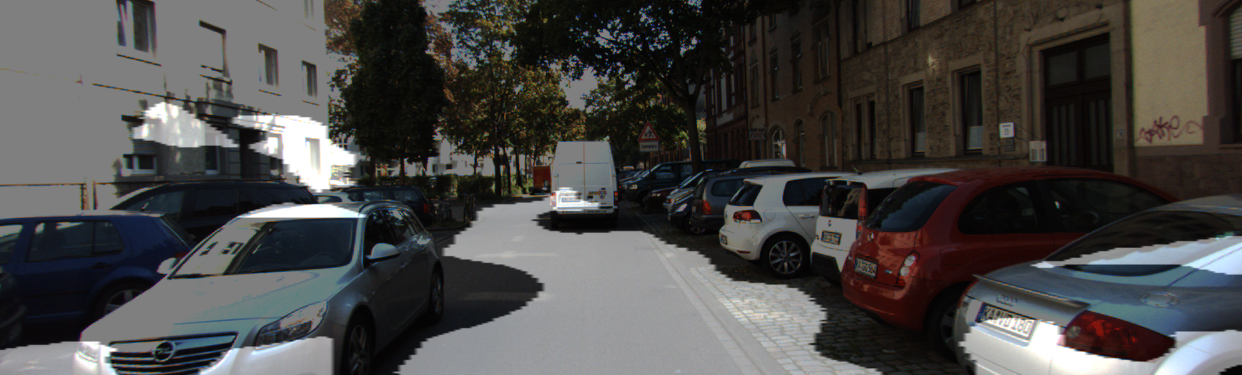

0.4098450120061122

In [74]:
output, prediction, target = get_output(
     model_unet_plus_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### unet 모델

In [57]:
model_path = dir_path + '/seg_model_unet.h5' 
unet = tf.keras.models.load_model(model_path) # epoch 100번

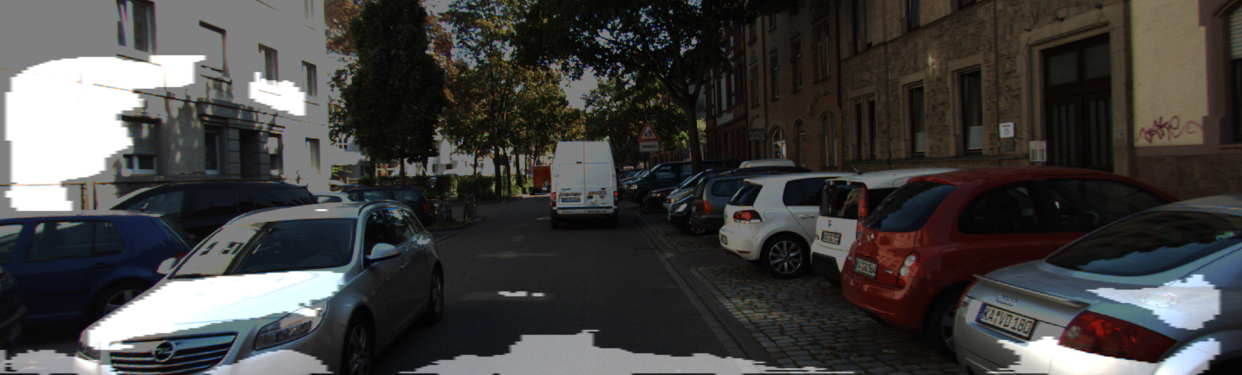

0.09676714722586283

In [75]:
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 추가실험

1. backbone을 해보려다가 input size문제와 많은 양의 코드로 시간이 부족해 실패했다.
- https://github.com/MrGiovanni/UNetPlusPlus <- unet++ 깃헙
- https://www.kaggle.com/code/meaninglesslives/nested-unet-with-efficientnet-encoder/notebook#Useful-Model-Blocks <- backbone kaggle

## 결과

- 1. UNet++ 모델의 결과
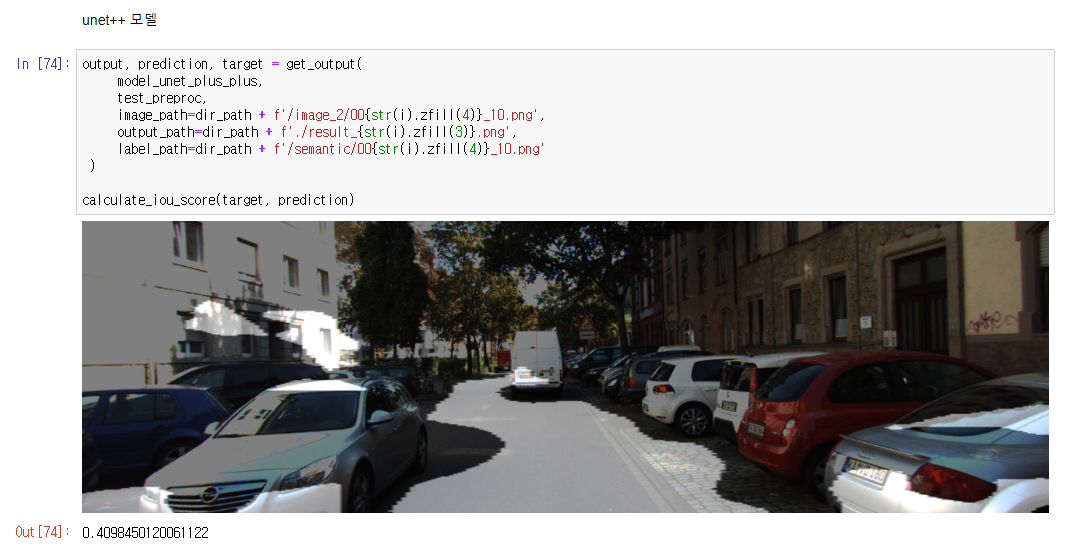  

- 2. UNet 모델의 결과
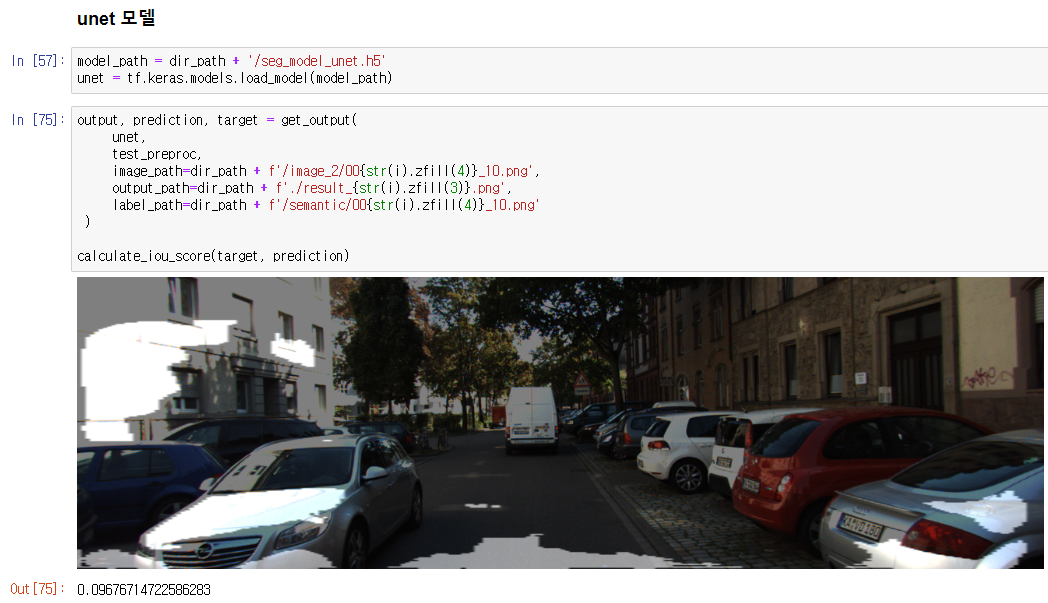  

    - 1번은 epoch을 40번 진행한 사진이고 2번은 epoch 100 번 진행한 사진인데 다른 경우는 거의 비슷하거나 unet이 iou 0.01정도 잘 나오는 것을 볼 수 있었다.

    - 1번의 경우가 도로를 더 잘 잡는 것 같은데 그러다가 인도까지 인식하는 경우가 많은 것 같았다.

## 회고

오늘 프로젝트를 진행하면서 새로운 customl_loss를 사용해 봤는데 흔히 쓰는 loss 처럼 일정하게 내려가는 느낌은 아니였던 것 같다.
이런 특이한 것들을 좀 찾아보고 알아보면 좋을 것 같다.

그리고 아쉬운 점은 backbone을 사용한 모델을 추가로 실험해 보면 좋을 것 같고 ealrystop을 넣어서 학습이 좀 빨리 끝난 것 같아서 풀고 좀 더 학습을 시키면 좋을 것 같다.

그리고 문제점이 있었는데 loss를 변경해서 진행했더니 save가 안되는 문제가 있었다. 이 문제도 해결해 봐야겠다.